In the set of experiments that follow, we are looking at the inference results of the baseline Interaction Network model and trying to understand how the model's performance changes under certain modifications of the dataset. 

The baseline model takes into account all 30 particle track features and 14 secondary vertex features. It allows 60 particle tracks and 5 secondary vertices, while any missing entry is zero-padded. Fully connected particle-particle and particle-vertex interaction graphs are constructed. The internal representation of both these graphs are represented by $D_e = 20$ dimensional latent spaces while the aggregator network's output has a dimension of $D_o = 24$. The internal representations of the interaction graphs are obtained by nonlinear functions $f_R^{pp}$ and $f_R^{vp}$, approximated by MLP networks with three dense layers each followed by RELU activation layer with 60 nodes for each of the first two layers and the final layer has a dimension of $D_e$. The aggregator function, $f_O$, is also approximated by a similar three layer MLP with the final layer dimension being $D_o$.

In the following sections, the experiments we perform sought to verify a number of aspects about the Interaction Network model, including-
- the model's invariance under permulation of particle tracks 
- the model's performance by simply zeroing out all features for certain tracks/vertices
- the model's performance by omitting certain features for all tracks/vertices

First we start out by loading the necessary packages and modules.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from gnn import GraphNetnoSV
from gnn import GraphNet
from gnn import GraphNetAllParticle
from data import H5Data
import glob
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

Now, let's define the necessary metadata- feature names and hyperparameters of the model.

In [2]:
params = ['track_ptrel',
          'track_erel',
          'track_phirel',
          'track_etarel',
          'track_deltaR',
          'track_drminsv',
          'track_drsubjet1',
          'track_drsubjet2',
          'track_dz',
          'track_dzsig',
          'track_dxy',
          'track_dxysig',
          'track_normchi2',
          'track_quality',
          'track_dptdpt',
          'track_detadeta',
          'track_dphidphi',
          'track_dxydxy',
          'track_dzdz',
          'track_dxydz',
          'track_dphidxy',
          'track_dlambdadz',
          'trackBTag_EtaRel',
          'trackBTag_PtRatio',
          'trackBTag_PParRatio',
          'trackBTag_Sip2dVal',
          'trackBTag_Sip2dSig',
          'trackBTag_Sip3dVal',
          'trackBTag_Sip3dSig',
          'trackBTag_JetDistVal'
         ]

params_sv = ['sv_ptrel',
          'sv_erel',
          'sv_phirel',
          'sv_etarel',
          'sv_deltaR',
          'sv_pt',
          'sv_mass',
          'sv_ntracks',
          'sv_normchi2',
          'sv_dxy',
          'sv_dxysig',
          'sv_d3d',
          'sv_d3dsig',
          'sv_costhetasvpv'
         ]

Np = len(params)        ## Number of particle track features
Nsv = len(params_sv)    ## Number of secondary vertex features
Ntracks = 60            ## Number of tracks being considered
Nclasses = 2            ## Number of classes for the output
Nverts = 5               ## Number of secondary vertices
batch_size = 1024       
hidden = 60             ## Number of nodes in each hidden layer of the NN
De = 20                 ## Dimension of internal representation
Do = 24                 ## Dimension of aggregator function 

Now we will load the dataset. We will only consider the validation dataset for our inference and evaluation purposes.

In [3]:
files = glob.glob("dataset/train/newdata_*.h5")
files_val = files[:5] # take first 5 for validation
data_val = H5Data(batch_size = batch_size,
                  cache = None,
                  preloading=0,
                  features_name='training_subgroup',
                  labels_name='target_subgroup',
                  spectators_name='spectator_subgroup')
data_val.set_file_names(files_val)

Now we will define the model and load the trained model.

In [4]:
softmax = torch.nn.Softmax(dim=1)

gnn = GraphNet(n_constituents = Ntracks, 
               n_targets = Nclasses, 
               params = len(params), 
               hidden = hidden, 
               n_vertices = Nverts, 
               params_v = len(params_sv),
               vv_branch=0,
               De=De,
               Do=Do)
gnn.load_state_dict(torch.load('IN_training/gnn_new_DR0_best.pth'))
training_all = []
training_sv_all = []

Let's define a method to perform model inference. We will allow this method to have necessary flexibilities so that it can be used to perform all the tests that follow.

In [5]:
def eval(track_column_shuffle = torch.tensor(np.arange(Ntracks), dtype=torch.long),
         vertex_column_shuffle = torch.tensor(np.arange(Nverts), dtype=torch.long),
         drop_tracks = torch.tensor([], dtype=torch.long),
         drop_pfeatures = torch.tensor([], dtype=torch.long),
         drop_svfeatures = torch.tensor([], dtype=torch.long),
         sort_vertices = False,
         sort_tracks = False,
         save_data = False):
    lst = []
    correct = []
    
    with torch.no_grad():
        for sub_X,sub_Y,sub_Z in data_val.generate_data():# tqdm.tqdm(,total=n_train/batch_size):                                                                   
            training = sub_X[2]
            training_sv = sub_X[3]
            target = sub_Y[0]
            spec = sub_Z[0]
            if save_data:
                training_all.append(training)
                training_sv_all.append(training_sv)
            
            ## Engineering tracks based on evaluation criteria
            
            trainingv = (torch.FloatTensor(training)).cuda()
            
            if sort_tracks: # sorting tracks by energy => index 1 of the feature list
                _, inds = torch.sort(torch.tensor(trainingv[:,1,:]), descending=True)
                for ii in range(trainingv.shape[0]):
                    trainingv[ii] = trainingv[ii][:,inds[ii]]
            else:
                trainingv = trainingv[:,:,track_column_shuffle]
            if len(drop_tracks) > 0:
                trainingv[:,:,drop_tracks] *= 0
            if len(drop_pfeatures) > 0:
                trainingv[:,drop_pfeatures,:] *= 0
            
            ## Engineeing vertices based on evaluation criteria
            
            trainingv_sv = (torch.FloatTensor(training_sv)).cuda()
            if sort_vertices:
                _, inds = torch.sort(torch.tensor(trainingv_sv[:,1,:]), descending=True)
                for ii in range(trainingv.shape[0]):
                    trainingv[ii] = trainingv[ii][:,inds[ii]]
            else:
                trainingv_sv = trainingv_sv[:,:,vertex_column_shuffle]
            if len(drop_svfeatures) > 0:
                trainingv_sv[:,drop_svfeatures,:] *= 0
            # targetv = (torch.from_numpy(np.argmax(target, axis = 1)).long()).cuda()
    
            out = gnn(trainingv.cuda(), trainingv_sv.cuda())
            lst.append(softmax(out).cpu().data.numpy())
            correct.append(target)
    
    predicted = np.concatenate(lst)
    val_targetv = np.concatenate(correct)
    
    return predicted, val_targetv



Now we define a class to get some plots and metrics about the model performance. The following class will calculate AUC for ROC and Precision-Recall curves, along with the fidelity score when compared with the baseline model's performance. We are also defining some methods that will generate bar charts for the change in AUC and change in Fidelity score for different choices of feature pruning.

In [6]:
class ModelComparison:
    def __init__(self, preds, targets, model_tags):
        self.preds = preds
        self.targets = targets
        self.n_models = len(preds)
        self.model_tags = model_tags
        self.aucs_roc = []
        self.aucs_prc = []
        self.fidelity = []
        
    def plot_roc(self, fname):
        if len(self.preds) > 4:
            plt.figure(figsize=(8,8))
        else:
            plt.figure(figsize=(4,4))    
        for ii in range(self.n_models):
            fpr, tpr, _ = roc_curve(self.targets[ii], self.preds[ii])
            self.aucs_roc.append(auc(fpr, tpr))
            #print(self.model_tags[ii])
            plt.plot(fpr, tpr, 
                     label=self.model_tags[ii] + " ({:.2f}%)".format(self.aucs_roc[ii]*100))
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim([1e-5, 1.00])
        plt.ylim([1e-2, 1.00])
        plt.xlabel('FPR', fontsize = 15)
        plt.ylabel('TPR', fontsize = 15)
        plt.legend(loc='lower right')
        plt.savefig(fname, bbox_inches='tight')
        plt.show()
        return self.aucs_roc
    
    def plot_prc(self, fname):
        if len(self.preds) > 4:
            plt.figure(figsize=(8,8))
        else:
            plt.figure(figsize=(4,4))
        for ii in range(self.n_models):
            precision, recall, _ =  precision_recall_curve(self.targets[ii], self.preds[ii])
            self.aucs_prc.append(auc(recall, precision))
            #print(self.model_tags[ii])
            plt.plot(recall, precision, 
                     label=self.model_tags[ii] + " ({:.2f}%)".format(self.aucs_prc[ii]*100))
        plt.xlabel('Recall', fontsize = 15)
        plt.ylabel('Precision', fontsize = 15)
        plt.legend(loc='lower left')
        plt.savefig(fname, bbox_inches='tight')
        plt.show()
        return self.aucs_prc
    
    def get_fidelity(self, pred_0):
        for ii in range(self.n_models):
            self.fidelity.append(1.0 - np.mean(np.abs(pred_0 - self.preds[ii])))
        return self.fidelity

def print_scores(vals, model_tags, mode='roc' ):
    if mode == 'roc':
        statement = "ROC AUC for {}: {:.2f}%"
    if mode == 'prc':
        statement = "PRC AUC for {}: {:.2f}%"
    if mode == 'fidelity':
        statement = "Fidelity for {}: {:.2f}%"
    for ii in range(len(model_tags)):
        print(statement.format(model_tags[ii], vals[ii]*100))
        
def dAUC_chart(dAUC_vals_roc, tags, fname, dAUC_vals_prc=[]):
    plot_auc_rpc = False
    if len(dAUC_vals_prc) == len(dAUC_vals_roc):
        kfact = 2
        plot_auc_rpc = True
    else:
        kfact = 1
    pos = kfact*np.arange(len(dAUC_vals_roc))
    if len(tags) < 10:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(8,6))
    plt.bar(pos, dAUC_vals_roc, align='center', label='ROC curve')
    if plot_auc_rpc:
        plt.bar(pos+1, dAUC_vals_roc, align='center', label='Precision-Recall Curve')
    plt.xticks(pos+0.5*plot_auc_rpc, tags, rotation='vertical',size=12)
    plt.ylabel('Percent Drop in AUC', size=15)
    if plot_auc_rpc:
        plt.legend()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    
def fidelity_chart(fidelity_vals, tags, fname):
    if len(tags) < 10:
        plt.figure(figsize=(4,4))
    else:
        plt.figure(figsize=(8,8))
    pos = np.arange(len(fidelity_vals))
    plt.bar(pos, 1.0 - np.array(fidelity_vals), align='center')
    plt.xticks(pos, tags, rotation='vertical')
    plt.ylabel('1 - F')
    plt.savefig(fname)
    plt.show()

Let's get the baseline model prediction first and simultaneously save the input data

In [7]:
pred_0, target_0 = eval(save_data = True)

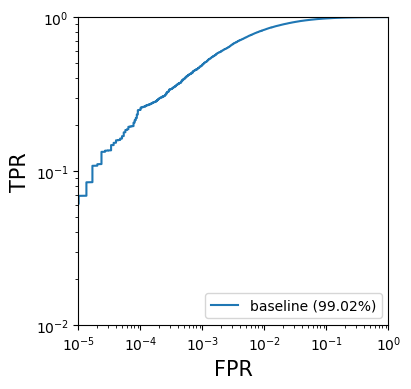

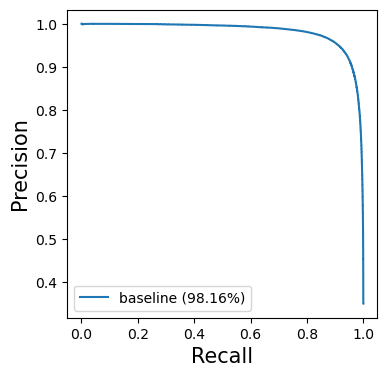

In [8]:
MC = ModelComparison([pred_0[:,1]], 
                     [target_0[:,1]], 
                     model_tags = ['baseline'])
_ = MC.plot_roc(fname = 'plots_xAI/baseline_roc.png')
_ = MC.plot_prc(fname = 'plots_xAI/baseline_prc.png')

### Test-1: Permutation of particle tracks. 

IN is expected to be invariant under particle track permutation. Here, we perform a random permutation of the input particle tracks as well as the secondary vertices and re-evaluate the model's performance. We'll look at the ROC curve for permuted inputs and compare it with the baseline. Verifying the permutation invariance of the network is going to be important for the tests that follow, since we will rearrange our tracks and vertices according to their relative energy and we want to make sure that the performance of the network doesn't change under such permutations.

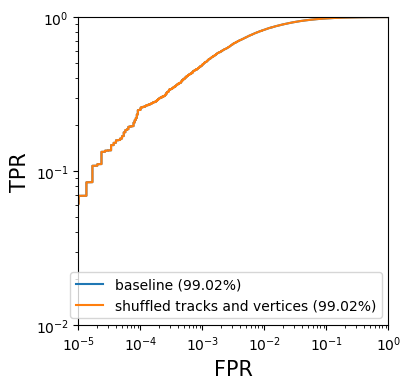

ROC AUC for baseline: 99.02%
ROC AUC for shuffled tracks and vertices: 99.02%


In [9]:
import random
cols_track = list(range(Ntracks))
cols_vertex = list(range(Nverts))
random.shuffle(cols_track)
random.shuffle(cols_vertex)
pred_shuffle, target_shuffle = eval(track_column_shuffle  = cols_track,
                                    vertex_column_shuffle = cols_vertex)

MC = ModelComparison([pred_0[:,1], pred_shuffle[:,1]], 
                     [target_0[:,1], target_shuffle[:,1]], 
                     model_tags = ['baseline', 'shuffled tracks and vertices'])
auc_rocs = MC.plot_roc(fname = 'plots_xAI/colshuffle_roc.png')
print_scores(mode='roc', vals = auc_rocs, model_tags = ['baseline', 'shuffled tracks and vertices'])

### Test-2a: Dropping last N particle tracks 

We have now seen that the network ids invariant under track and vertex permutations. We will take advantage of this and rearrange the inputs according to their relative energy. The feature `track_erel` and `sv_erel` represent the relative energy of a track and a secondary vertex with respect to the energy of the jet. The baseline model of the IN takes into account all 60 particle tracks associated with each jet event. In this test, we will drop a certain number of the lowest energy tracks by zeroing out the corresponding entries and evaluate the performance of the trained model.

Besides the usual metric of the AUC score of the ROC curve, we will use a second metric to evaluate the average performance of the model. This metric, called *Fidelity* is a measure of how faithfully one model represents the performance of another model over the entire sample space. It is determined by comparing the classification scores of two models-

\begin{equation}
F(\mathcal{M}_1, \mathcal{M}_2) = 1 - \frac{1}{N}\sum_{i=0}^{N-1} |\hat{y}_1(x_i) -  \hat{y}_2(x_i)|
\end{equation}

where $\mathcal{M}_1$ and $\mathcal{M}_2$ are two different models and the corresponding classifier scores are respectively given by $\hat{y}_1(x_i)$ and  $\hat{y}_2(x_i)$

/home/avroy/.conda/envs/avroy_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


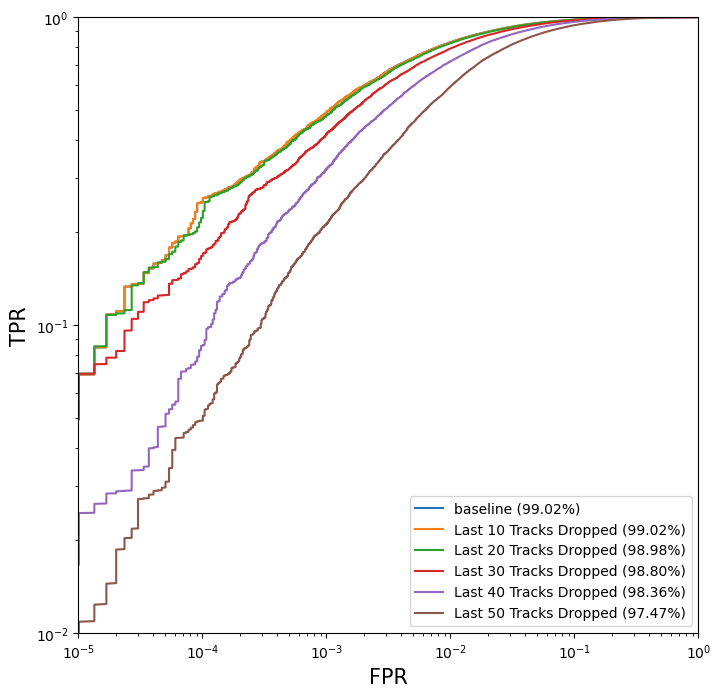

Fidelity for baseline: 100.00%
Fidelity for Last 10 Tracks Dropped: 99.95%
Fidelity for Last 20 Tracks Dropped: 99.62%
Fidelity for Last 30 Tracks Dropped: 98.12%
Fidelity for Last 40 Tracks Dropped: 94.30%
Fidelity for Last 50 Tracks Dropped: 89.57%


In [10]:
drop_counts = [10, 20, 30, 40, 50]
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for dc in drop_counts:
    drop_tracks = list(range(60-dc, 60))
    _p, _t = eval(sort_tracks = True, drop_tracks = drop_tracks)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Last {} Tracks Dropped".format(dc))


MC = ModelComparison(preds, targets, tags)
auc_rocs = MC.plot_roc(fname = 'plots_xAI/last_tracks_dropped_roc.png')
fidelity = MC.get_fidelity(preds[0])
print_scores(mode='fidelity', vals=fidelity, model_tags=tags)

In the previous test, we have seen the dropping the last few tracks has very little impact on the model's performance. We start to see a noticable degradation of the ROC curve when 30 tracks are dropped and it gets worse as more tracks are dropped. A similar tresnd is observed with the Fidelity score. This is what we would expect. 

### Test-2b: Dropping first N particle tracks

Now we will repeat the same test as the previous one, but this time only the most energetic N tracks will be dropped. 

/home/avroy/.conda/envs/avroy_py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


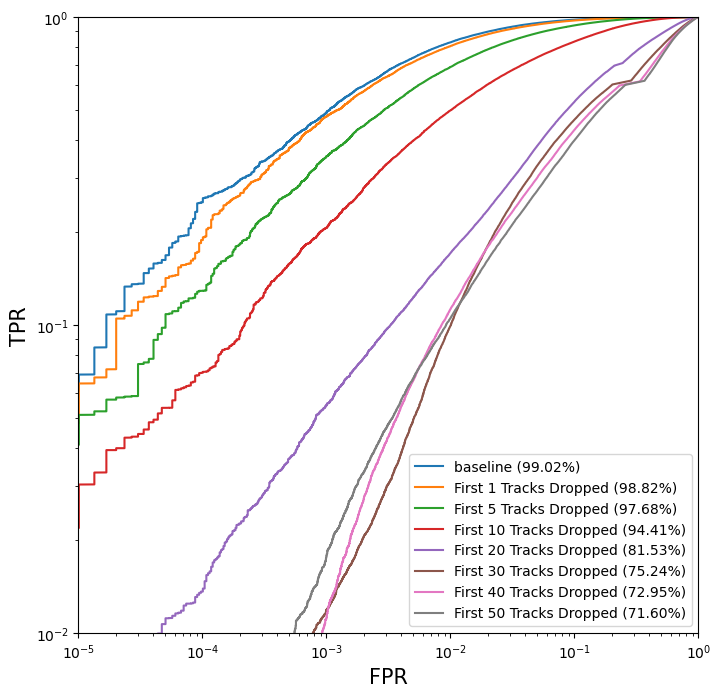

Fidelity for baseline: 100.00%
Fidelity for First 1 Tracks Dropped: 97.78%
Fidelity for First 5 Tracks Dropped: 93.28%
Fidelity for First 10 Tracks Dropped: 87.25%
Fidelity for First 20 Tracks Dropped: 75.26%
Fidelity for First 30 Tracks Dropped: 71.52%
Fidelity for First 40 Tracks Dropped: 70.63%
Fidelity for First 50 Tracks Dropped: 70.16%


In [11]:
drop_counts = [1, 5, 10, 20, 30, 40, 50]
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for dc in drop_counts:
    drop_tracks = list(range(dc))
    _p, _t = eval(sort_tracks= True, drop_tracks = drop_tracks)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("First {} Tracks Dropped".format(dc))


MC = ModelComparison(preds, targets, tags)
auc_rocs = MC.plot_roc(fname = 'plots_xAI/first_tracks_dropped_roc.png')
fidelity = MC.get_fidelity(preds[0])
print_scores(mode='fidelity', vals=fidelity, model_tags=tags)

One can see that the network's performance almost immediately starts to degrade as soon as the highest energy track is dropped. By the point 10 tracks have been dropped, the network is left with very little viable information to make meaningful predictions. Hence, as one would typically expect, the highest energy tracks have a more significant contribution in the network's decision making process.


### Test-3a: Dropping particle features one-by-one

Now we will try to see how important individual features are in making the prediction. We will drop features one at a time, by simply masking them with zero values, and run inference with the network. Then we will compare the AUC score from the inference values and compare them with the basline AUC score. This metric of change in AUC will give us a relative ranking of the input features. 

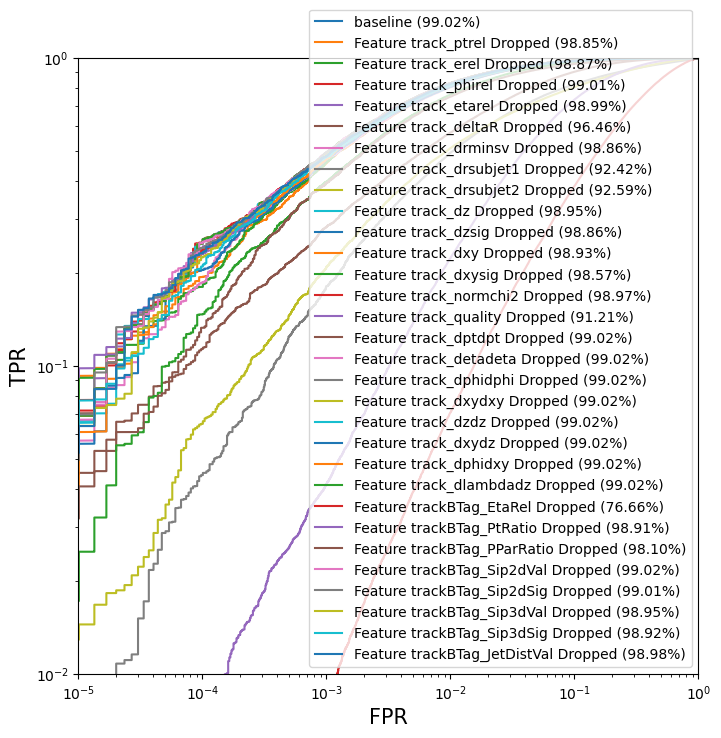

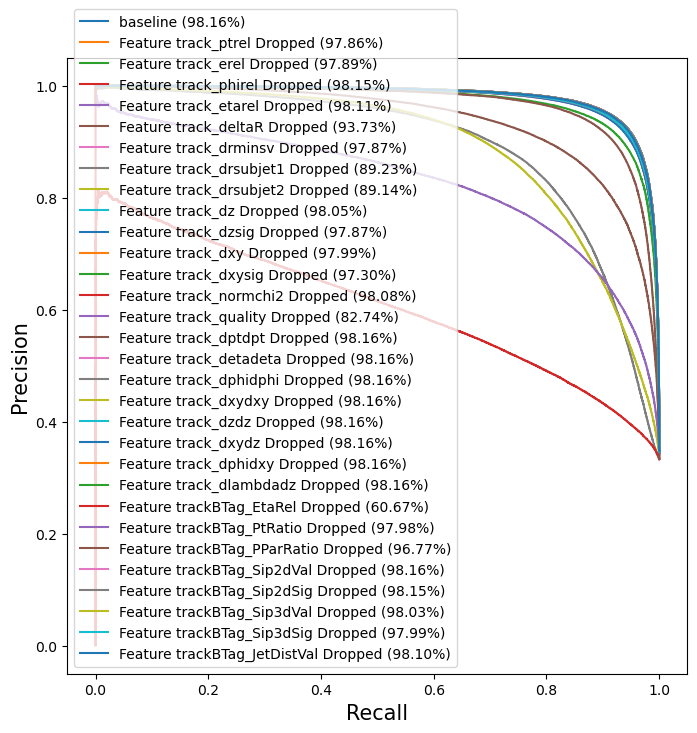

In [12]:
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for ii in range(Np):
    drop_features = [ii]
    _p, _t = eval(drop_pfeatures = drop_features)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Feature {} Dropped".format(params[ii]))


MC = ModelComparison(preds, targets, tags)
drop_pfeatures_roc_auc = MC.plot_roc(fname = "plots_xAI/roc_droptracks.png")
drop_pfeatures_prc_auc = MC.plot_prc(fname = "plots_xAI/prc_droptracks.png")
fidelity_pfeatures = MC.get_fidelity(preds[0])

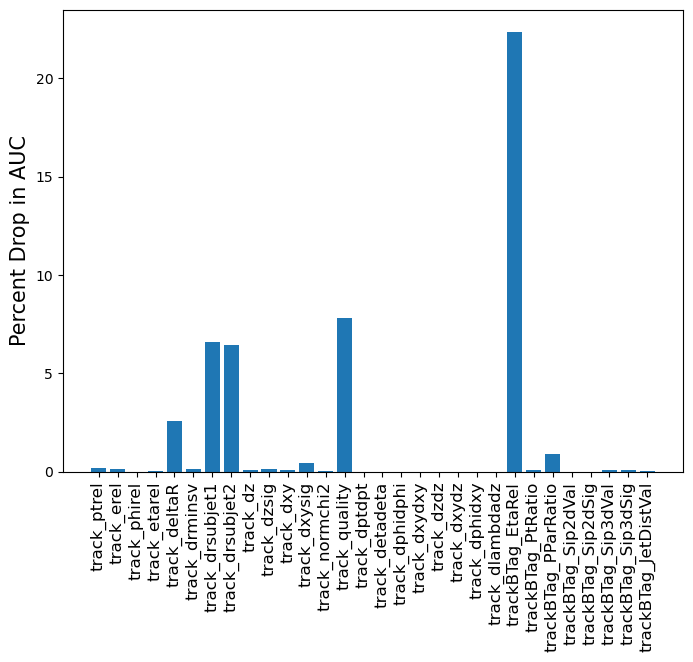

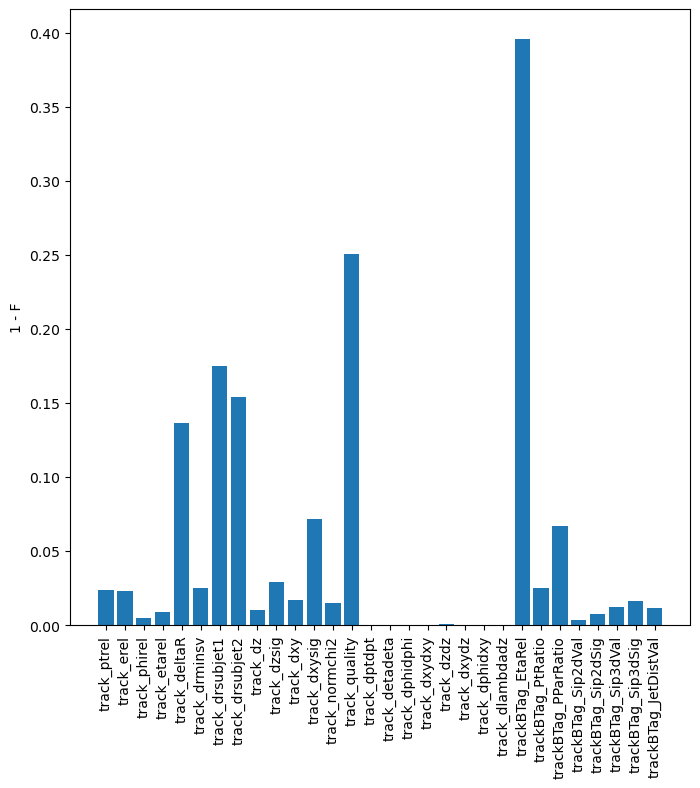

In [13]:
drop_pfeatures_roc_delauc = (drop_pfeatures_roc_auc[0] - np.array(drop_pfeatures_roc_auc))[1:]*100
drop_pfeatures_prc_delauc = (drop_pfeatures_prc_auc[0] - np.array(drop_pfeatures_prc_auc))[1:]*100
dAUC_chart(dAUC_vals_roc = drop_pfeatures_roc_delauc, 
           tags = params, 
           fname = "plots_xAI/dAUC_chart_tracks.png")
fidelity_chart(fidelity_vals = fidelity_pfeatures[1:], 
               tags = params, 
               fname = "plots_xAI/fidelity_chart_tracks.png")

These results show a very interesting fact. Many of the features have a very small contribution in model inference. In fact, simply omitting them from the input data has almost no effect on the AUC or Fidelity scores. On the other hand, masking of some features, e.g. `track_quality` and `trackBTag_EtaRel`, shows a much larger impact on the model's performance.

### Test-3b: Dropping vertex features one-by-one

We will now repeat that test, but for individual vertex features. By examining the change in AUC and Fidelity scores, this test will determine the impact of dropping individual vertex features


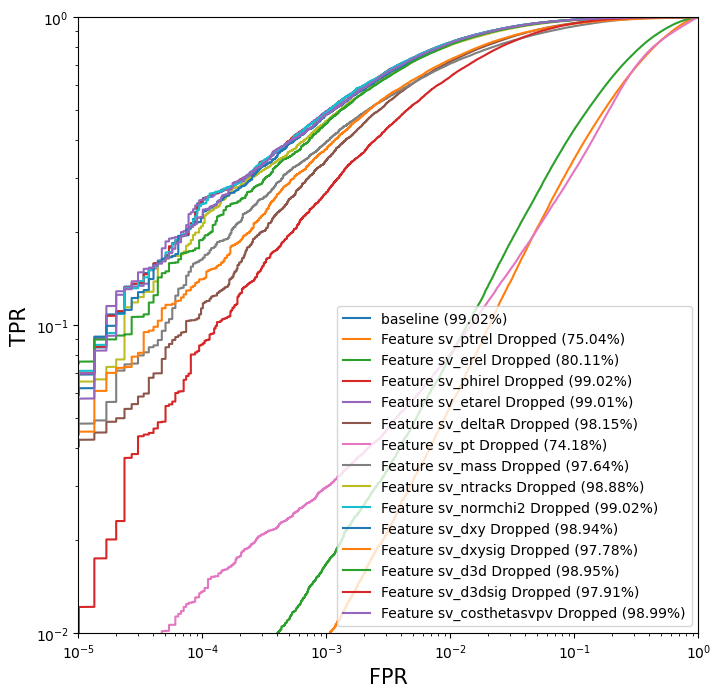

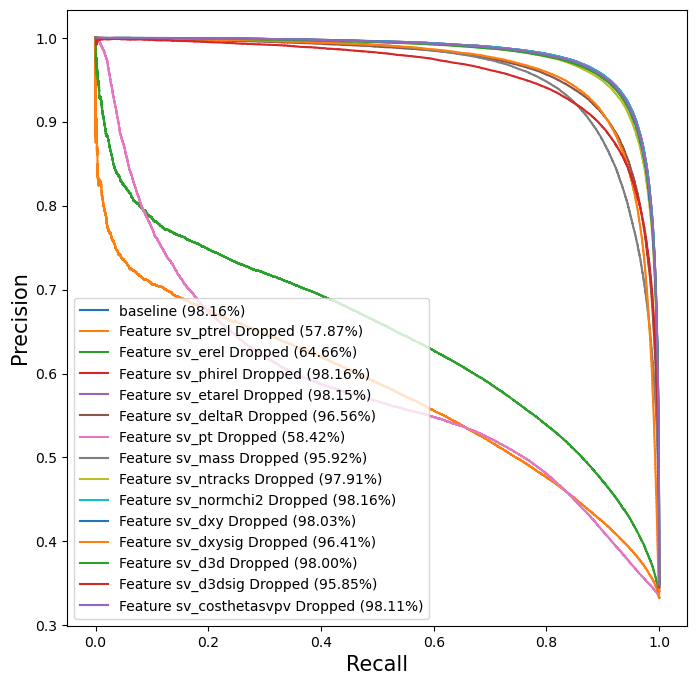

In [14]:
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for ii in range(Nsv):
    drop_features = [ii]
    _p, _t = eval(drop_svfeatures = drop_features)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Feature {} Dropped".format(params_sv[ii]))


MC = ModelComparison(preds, targets, tags)
drop_svfeatures_roc_auc = MC.plot_roc(fname = "plots_xAI/roc_dropverts.png")
drop_svfeatures_prc_auc = MC.plot_prc(fname = "plots_xAI/roc_dropverts.png")
fidelity_svfeatures = MC.get_fidelity(preds[0])

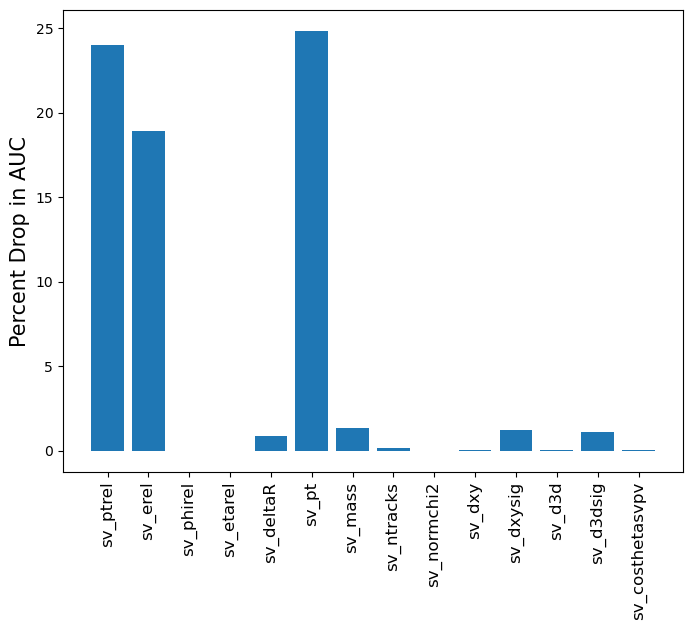

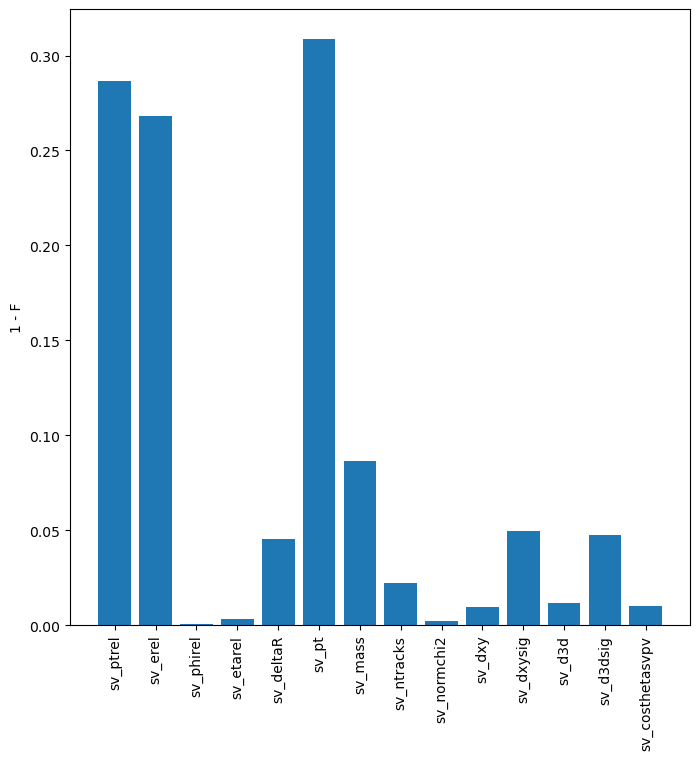

In [15]:
drop_svfeatures_roc_delauc = (drop_svfeatures_roc_auc[0] - np.array(drop_svfeatures_roc_auc))[1:]*100
drop_svfeatures_prc_delauc = (drop_svfeatures_prc_auc[0] - np.array(drop_svfeatures_prc_auc))[1:]*100
dAUC_chart(dAUC_vals_roc = drop_svfeatures_roc_delauc, 
           tags = params_sv, 
           fname = "plots_xAI/dAUC_chart_verts.png")
fidelity_chart(fidelity_vals = fidelity_svfeatures[1:], 
               tags = params_sv, 
               fname = "plots_xAI/fidelity_chart_verts.png")

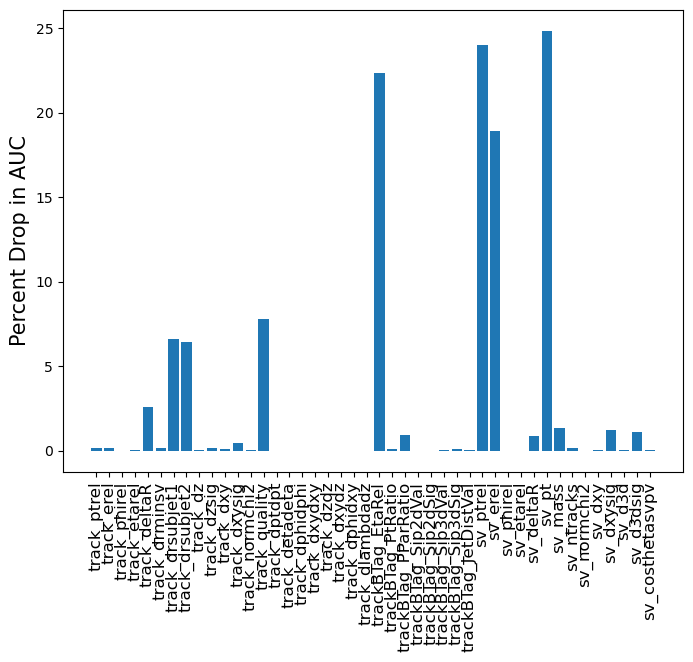

In [16]:
drop_psvfeatures_roc_delauc = np.append(drop_pfeatures_roc_delauc, drop_svfeatures_roc_delauc)
dAUC_chart(dAUC_vals_roc = drop_psvfeatures_roc_delauc, 
           tags = params + params_sv, 
           fname = "plots_xAI/dAUC_chart_tracksNverts.png")

### Model simplification by feature reduction

Since we have seen many of the particle track and vertex features contribute only marginally to the model's performance, it is worth investigating what happens if drop many of such features at the same time. Now let's see what happens if we drop all particle features for which the change in AUC is less than some threshold. We are arbitrarily choosing the thresholds at 0.001, 0.005, 0.01, 0.05, and 1%

First, we will only drop particle track features and keep all the secondary vertex features.

Dropping features [14, 15, 16, 17, 18, 19, 20, 21] for threshold = 0.001%
Dropping features [14, 15, 16, 17, 18, 19, 20, 21, 25] for threshold = 0.005%
Dropping features [2, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26] for threshold = 0.01%
Dropping features [2, 3, 12, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 29] for threshold = 0.05%
Dropping features [0, 1, 2, 3, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29] for threshold = 1%


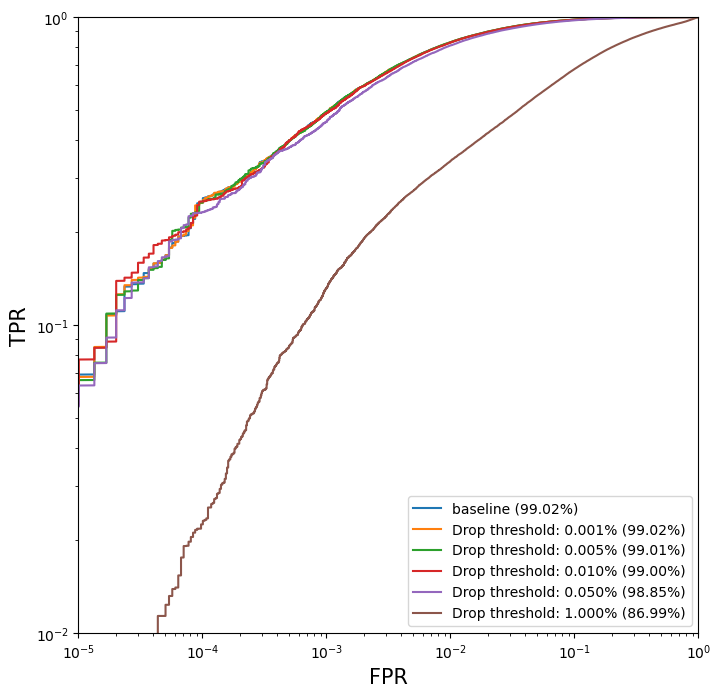

In [17]:
thresholds = [0.001, 0.005, 0.01, 0.05, 1]
n_pfeatures_dropped = []
dropped_pfeatures = []
n_svfeatures_dropped = []
dropped_svfeatures = []
cum_auc_dropped = []
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for th in thresholds:
    drop_pfeatures = list(np.where(drop_pfeatures_roc_delauc < th)[0])
    dropped_pfeatures.append(drop_pfeatures)
    n_pfeatures_dropped.append(len(drop_pfeatures))
    print("Dropping features {} for threshold = {}%".format(drop_pfeatures, th))
    # drop_svfeatures = list(np.where(drop_svfeatures_roc_delauc < th)[0])
    # dropped_svfeatures.append(drop_svfeatures)
    # n_svfeatures_dropped.append(len(drop_svfeatures))
    cum_auc_dropped.append(np.sum(drop_pfeatures_roc_delauc[drop_pfeatures]))
    _p, _t = eval(drop_pfeatures = drop_pfeatures)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Drop threshold: {:.3f}%".format(th))


MC = ModelComparison(preds, targets, tags)
featdropped_ponly_aucs = MC.plot_roc(fname = "plots_xAI/roc_droptracks_threshold.png")
fidelity_pfeatures = MC.get_fidelity(preds[0])

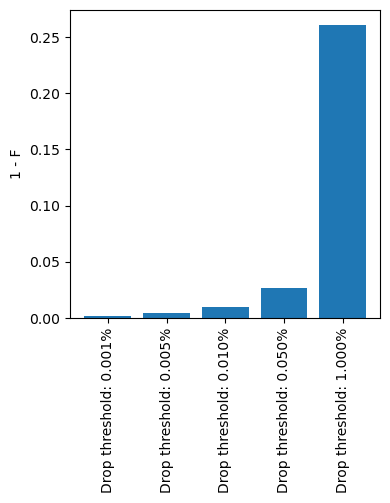

In [18]:
fidelity_chart(fidelity_vals = fidelity_pfeatures[1:], 
               tags = tags[1:], 
               fname = "plots_xAI/fidelity_chart_droptracks_threshold.png")
# plt.figure(figsize=(8,8))
# pos = np.arange(len(fidelity_pfeatures[1:]))
# plt.bar(pos, fidelity_pfeatures[1:], align='center')
# plt.xticks(pos, tags[1:], rotation='vertical')
# plt.ylabel('Fidelity Score')
# plt.show()

We can see that even dropping multiple particle track features at the same time creates only small change in the model's performance. For instance, at a threshold of 0.01%, we can drop up to 11 of the 30 features. This is an intriguing observation. It implies the model has the capacity to learn jet classification with only a minor subset of the input track features. This also hints that it could be possible to reduce the model complexity. We will explore these directions later. Now let's see what happens when we drop multiple secondary vertex features at the same time.

Dropping features [2, 8] for threshold = 0.001%
Dropping features [2, 8] for threshold = 0.005%
Dropping features [2, 3, 8] for threshold = 0.01%
Dropping features [2, 3, 8, 13] for threshold = 0.05%
Dropping features [2, 3, 4, 7, 8, 9, 11, 13] for threshold = 1%


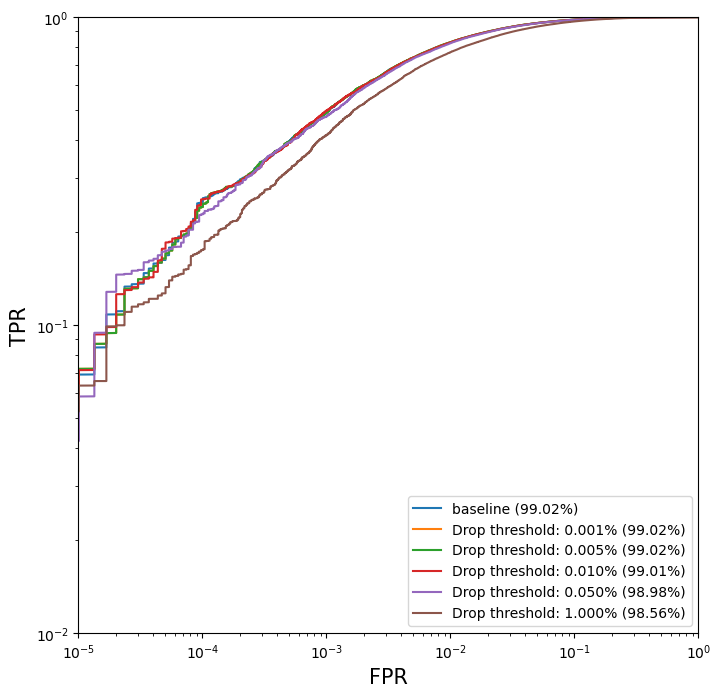

In [19]:
thresholds = [0.001, 0.005, 0.01, 0.05, 1]
n_pfeatures_dropped = []
dropped_pfeatures = []
n_svfeatures_dropped = []
dropped_svfeatures = []
cum_auc_dropped = []
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for th in thresholds:
#     drop_pfeatures = list(np.where(drop_pfeatures_roc_delauc < th)[0])
#     dropped_pfeatures.append(drop_pfeatures)
#     n_pfeatures_dropped.append(len(drop_pfeatures))
    drop_svfeatures = list(np.where(drop_svfeatures_roc_delauc < th)[0])
    dropped_svfeatures.append(drop_svfeatures)
    n_svfeatures_dropped.append(len(drop_svfeatures))
    print("Dropping features {} for threshold = {}%".format(drop_svfeatures, th))
    cum_auc_dropped.append(np.sum(drop_svfeatures_roc_delauc[drop_svfeatures]))
    _p, _t = eval(drop_svfeatures = drop_svfeatures)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Drop threshold: {:.3f}%".format(th))


MC = ModelComparison(preds, targets, tags)
featdropped_ponly_aucs = MC.plot_roc(fname = "plots_xAI/roc_dropverts_threshold.png")
fidelity_svfeatures = MC.get_fidelity(preds[0])

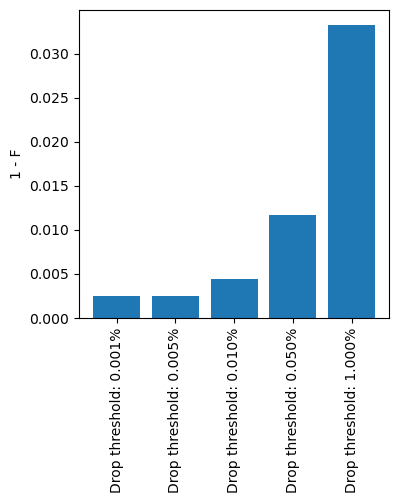

In [20]:
fidelity_chart(fidelity_vals = fidelity_svfeatures[1:], 
               tags = tags[1:], 
               fname = "plots_xAI/fidelity_chart_dropverts_threshold.png")

Our Now let's see what happens if we drop all particle and vertex features that gets a delta(AUC) < some_threshold.
Choosing thresholds of 0.001, 0.005, 0.01, 0.05, and 1%

Dropping p features [14, 15, 16, 17, 18, 19, 20, 21] for threshold = 0.001%
Dropping sv features [2, 8] for threshold = 0.001%
Dropping p features [14, 15, 16, 17, 18, 19, 20, 21, 25] for threshold = 0.005%
Dropping sv features [2, 8] for threshold = 0.005%
Dropping p features [2, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26] for threshold = 0.01%
Dropping sv features [2, 3, 8] for threshold = 0.01%
Dropping p features [2, 3, 12, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 29] for threshold = 0.05%
Dropping sv features [2, 3, 8, 13] for threshold = 0.05%
Dropping p features [0, 1, 2, 3, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29] for threshold = 1%
Dropping sv features [2, 3, 4, 7, 8, 9, 11, 13] for threshold = 1%


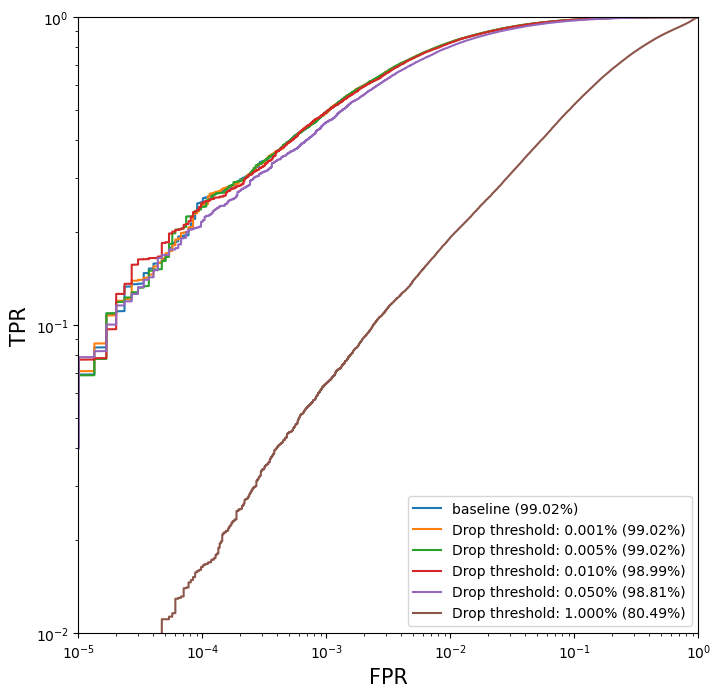

In [21]:
thresholds = [0.001, 0.005, 0.01, 0.05, 1]
n_pfeatures_dropped = []
dropped_pfeatures = []
n_svfeatures_dropped = []
dropped_svfeatures = []
cum_auc_dropped = []
preds = [pred_0[:,1]]
targets = [target_0[:,1]]
tags = ['baseline']

for th in thresholds:
    drop_pfeatures = list(np.where(drop_pfeatures_roc_delauc < th)[0])
    dropped_pfeatures.append(drop_pfeatures)
    n_pfeatures_dropped.append(len(drop_pfeatures))
    print("Dropping p features {} for threshold = {}%".format(drop_pfeatures, th))
    drop_svfeatures = list(np.where(drop_svfeatures_roc_delauc < th)[0])
    dropped_svfeatures.append(drop_svfeatures)
    n_svfeatures_dropped.append(len(drop_svfeatures))
    print("Dropping sv features {} for threshold = {}%".format(drop_svfeatures, th))
    cum_auc_dropped.append(np.sum(drop_svfeatures_roc_delauc[drop_svfeatures]))
    _p, _t = eval(drop_svfeatures = drop_svfeatures, drop_pfeatures = drop_pfeatures)
    preds.append(_p[:,1])
    targets.append(_t[:,1])
    tags.append("Drop threshold: {:.3f}%".format(th))


MC = ModelComparison(preds, targets, tags)
featdropped_psv_aucs = MC.plot_roc(fname = "plots_xAI/roc_droptracksNverts_threshold.png")
fidelity_psvfeatures = MC.get_fidelity(preds[0])

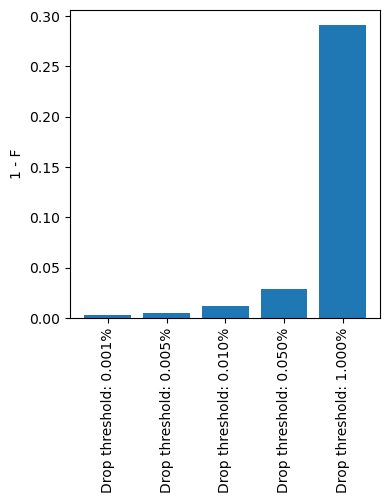

Fidelity for baseline: 100.00%
Fidelity for Drop threshold: 0.001%: 99.69%
Fidelity for Drop threshold: 0.005%: 99.46%
Fidelity for Drop threshold: 0.010%: 98.85%
Fidelity for Drop threshold: 0.050%: 97.12%
Fidelity for Drop threshold: 1.000%: 70.83%


In [22]:
fidelity_chart(fidelity_vals = fidelity_psvfeatures[1:], 
               tags = tags[1:], 
               fname = "plots_xAI/fidelity_chart_droptracksNverts_threshold.png")
print_scores(mode='fidelity', vals=fidelity_psvfeatures, model_tags=tags)